In [216]:
import pandas as pd
import numpy as np
import string

In [36]:
data = pd.read_csv('train.csv')

In [24]:
data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [20]:
data['target'].value_counts()/data['target'].count()

0    0.57034
1    0.42966
Name: target, dtype: float64

In [222]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import nltk
nltk.download("stopwords")
nltk.download('punkt')
stemmer = EnglishStemmer()
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/ioana/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ioana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
data['text'].isnull().sum()
list_sentence = []
for i in range(len(data['text'])):
    token = word_tokenize(data['text'].iloc[i])
    list_sentence.append(token)
list_keywords = ((data['keyword'].value_counts()).reset_index())['index']
list_location = ((data['location'].value_counts()).reset_index())['index']
list_keywords = list(list_keywords)
list_location = list(list_location)
for i in range(len(list_keywords)):
    list_keywords[i] = list_keywords[i].replace('%20', ' ')

In [140]:
#examine only keywords for disaster tweets:
keywords1 = data[data['target'] == 1]['keyword'].value_counts().reset_index()['index']
keywords1 = list(keywords1)
for i in range(len(keywords1)):
    keywords1[i] = keywords1[i].replace('%20', ' ')

In [202]:
list_count = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    count = 0
    for j in range(len(sentence)):
        for k in range(len(keywords1)):
            if sentence[j].casefold() == keywords1[k].casefold() and len(keywords1[k].split()) == 1:
                count = count + 1
            elif len(keywords1[k].split()) == 2: #split words
                if sentence[j].casefold() == keywords1[k].split()[0].casefold() and j+1 < len(sentence):
                    if sentence[j+1].casefold() == keywords1[k].split()[1].casefold():
                        count = count + 1
    list_count.append(count)
data['keyword_count'] = list_count

In [204]:
data['target'].corr(data['keyword_count'])

0.28940562081058163

In [196]:
#cannot add punctuation or spaces to twitter hashtags
list_hashtags = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    list_pertweet = []
    for j in range(len(sentence)):
        if sentence[j] == '#' and j+1 < len(sentence):
            list_pertweet.append(sentence[j+1])
    if len(list_pertweet) > 0:
        list_hashtags.append(list_pertweet)
    else:
        list_hashtags.append(np.nan)
data['hashtags'] = list_hashtags

In [293]:
location1 = data[data['target'] == 1]['location'].value_counts().reset_index()['index']
list(location1)
location_tok = []
for i in range(len(location1)):
    token = word_tokenize(location1[i])
    token = list(filter(lambda token: token not in string.punctuation, token))
    location_tok.append(token)
#clean location for further processing
#lowercase letter
for i in range(len(location_tok)):
    filtered_sentence = [w for w in location_tok[i] if not w in stop_words]
    for j in range(len(filtered_sentence)):
        filtered_sentence[j] = filtered_sentence[j].casefold()
    location_tok[i] = filtered_sentence

In [239]:
#does having a hashtag affect disaster status
data['hashtags_bool'] = pd.notnull(data['hashtags'])
data['target'].corr(data['hashtags_bool'])

0.07414225496523114

In [332]:
#location and keyword in hashtag
set_location = set()
set_keywords = set()
list_count = []
for i in range(len(location_tok)):
    set_location = set_location.union(set(location_tok[i]))
set_keywords = set(keywords1)
for i in range(len(data['hashtags'])):
    hashtags = data['hashtags'].iloc[i]
    if hashtags != hashtags:
        list_count.append(0)
    else:
        for j in range(len(hashtags)):
            hashtags[j] = hashtags[j].casefold()
        union_l = set(hashtags).intersection(set_location)
        union_k = set(hashtags).intersection(set_keywords)
        list_count.append(len(union_l) + len(union_k))
data['hashtags_count'] = list_count

In [333]:
data['target'].corr(data['hashtags_count'])

0.11169258276380914

In [345]:
#repeating methodology with text
list_count = []
sentence_t = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    for j in range(len(sentence)):
        sentence_t.append(sentence[j].casefold())
    union_l = set(sentence).intersection(set_location)
    union_k = set(sentence).intersection(set_keywords)
    list_count.append(len(union_l) + len(union_k))
data['text_count'] = list_count

In [347]:
data['target'].corr(data['text_count'])

0.0565785399190264

In [351]:
#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [358]:
list_score = []
analyzer = SentimentIntensityAnalyzer()
for i in range(len(data['text'])):
    score = analyzer.polarity_scores(data['text'].iloc[i])
    list_score.append(score)

In [363]:
#list_score[0]['neg']
list_neg = []
list_neu = []
list_pos = []
list_compound = []
for i in range(len(list_score)):
    list_neg.append(list_score[i]['neg'])
    list_neu.append(list_score[i]['neu'])
    list_pos.append(list_score[i]['pos'])
    list_compound.append(list_score[i]['compound'])
data['neg'] = list_neg
data['neu'] = list_neu
data['pos'] = list_pos
data['compound'] = list_compound

In [371]:
data['target'].corr(data['neg']) #0.1298389384419161
data['target'].corr(data['neu']) #0.02670054925813727
data['target'].corr(data['pos']) #-0.20805222028816894
data['target'].corr(data['compound']) #-0.22776956071990492

-0.22776956071990492

In [373]:
import seaborn as sn

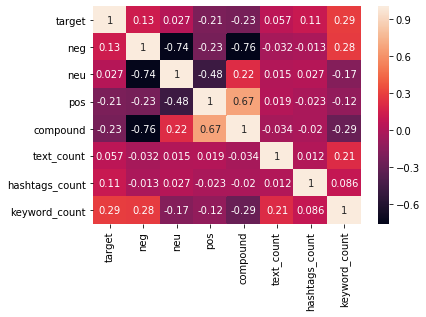

In [374]:
#correlation matrix
data_corr = data[['target', 'neg', 'neu', 'pos', 'compound', 'text_count', 'hashtags_count', 'keyword_count']]
corrMatrix = data_corr.corr()
sn.heatmap(corrMatrix, annot=True)